In [3]:
#from detect_coldpools_funct import read_ship, identify_onset_of_coldpool_candidates, find_minimum_of_coldpool, coldpool_end

import sys
import os
sys.path.append(os.path.abspath('../readers'))
from lidars import f_call_postprocessing_arthus
from cloud_types import read_rain_flags
from mrr import read_mrr_dsd_day
from era5 import read_era5


from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import cmcrameri.cm as cmc
import xarray as xr
import pandas as pd

TypeError: 'numpy._DTypeMeta' object is not subscriptable

In [2]:



DROP_VARIABLES = [
    'lcl',
    'P',
    'SST',
    'lat',
    'lon',
    'Hwind',
    'windDir'
    ]

def read_ship():
    '''
    Returns xarray dataset containing ship data with removed time duplicates
    -------
    '''    # reading ship data for t, p, Rh, SST, lat , lon
    ship_data = xr.open_dataset('/data/obs/campaigns/eurec4a/msm/ship_data/ship_dataset_allvariables.nc', drop_variables=DROP_VARIABLES)
    ship_data    # removing duplicated times
    _, index = np.unique(ship_data['time'], return_index=True)
    ship_data = ship_data.isel(time=index)    
    return ship_data


def identify_onset_of_coldpool_candidates(ds_T, index_coldpool_candidates):

    """
    Identifies the onset of cold pool events in a time-series dataset and marks them.

    The onset of the cold-pool front tmax is defined as: 
    - the last instance of δT > 0 K within 20 min before the initial abrupt temperature drop with δT < −0.05 K (coldpool_candidate). 
    - If the temperature is falling continuously in this period:
        --> tmax is choosen as the time of the maximum temperature 
    (that is, 20 min before the abrupt temperature drop). We refer to the smoothed temperature at tmax as Tmax.
    (Step 2. in the paper of Vogel et al 2021)
    
    Parameters:
    -----------
    ds_T : xarray.Dataset
        A dataset containing time-series data with temperature (`T_fil`) and temperature
        difference (`dT`) variables, along with a time coordinate. The dataset also contains
        a list of cold pool candidate indices (`index_coldpool_candidates`).

    Returns:
    --------
    ds : xarray.Dataset
        The updated dataset with a new variable `onset_cp` marking the cold pool onset times. 
        Values are set to 1 at the onset times and 0 otherwise.
    
    tmax_indexes : list of int
        A list of indices corresponding to the times of cold pool onsets in the dataset.
    """


    ds_T = ds_T.assign(onset_cp=(['time'],np.zeros(len(ds_T.time.values))))
    
    ds = ds_T
    tmax_indexes = []
    for i in index_coldpool_candidates:

        # Get the time of the abrupt drop
        abrupt_drop_time = ds['time'][i]
    
        # Create a window for 20 minutes before the abrupt drop
        start_time = abrupt_drop_time - np.timedelta64(20, 'm')
        time_window = ds.sel(time=slice(start_time, abrupt_drop_time))

        
        # 1. Find tmax (the onset of the cold pool)
        # Find the last instance of δT > 0 K within the 20-minute window
        tmax_condition = time_window['dT'] > 0
        tmax_times = time_window['time'].where(tmax_condition, drop=True)
        
        if len(tmax_times) > 0: #if tmax_times exists 
            # tmax is the last time where δT > 0 K
            tmax = tmax_times[-1]
            tmax = tmax.values

        
        # 2. If temperature is falling continuously, tmax is the time of the maximum temperature
        else:
            tmax_index_time_window = time_window['T_fil'].argmax(dim='time')
            tmax = time_window.time.values[tmax_index_time_window]
        
        # Only append the index of the onset if the index does not already exist 
        # (Different coldpool candidates have the same onset, because the temperature normally drops longer than just one timestamp)
        tmax_index = np.where(ds['time'] == tmax)[0][0]  
        if tmax_index not in tmax_indexes:
            tmax_indexes.append(tmax_index)
            
        # save the time of the onset
        ds['onset_cp'].loc[{'time': tmax}] = 1

    return ds, tmax_indexes



def find_minimum_of_coldpool(ds, ds_T, tmax_indices):
    '''
    
    Identify the minimum Temperature of T_fil (Tmin) of a coldpool (tmin), after tmax (the onset of the coldpool has already been identified)
    (Relates to the second step of identifying coldpools from the paper Vogel et. al. 2021)

    tmin is identified as:
    - The minimum of contiguous temperature minima in the dataset after each tmax time.
    - If there is a subsequent candidate cold pool within 20 minutes of a previous minimum, the two cold pools are 
      combined if the temperature in between does not rise by more than 0.5 K above the previous minimum.
    
    Parameters:
    - ds : xarray.Dataset
        The dataset containing temperature data and cold pool candidate indicators.
    - tmax_indices : list of int
        List of indices representing the onset times (tmax) of cold pool events.
    
    Returns:
    - ds : xarray.Dataset
        The updated dataset with an added 'minimum_of_cp' variable indicating Tmin for each cold pool event.
    - tmin_indices : list of int
        List of indices representing the minimum times (tmin) of each cold pool.
    
    Notes:
    - The function first finds Tmin after each tmax by identifying when `T_fil` starts rising after reaching a minimum.
    - If a subsequent cold pool candidate is detected (δT < -0.05 K) within 20 minutes of tmin, the two events are combined 
      if the temperature between the two events does not exceed Tmin by more than 0.5 K.
    - If cold pool events are combined, the later tmin is used as the effective minimum time, and the earlier tmax 
      is retained as the cold pool onset time.
    

    '''  
    ds = ds.assign(minimum_of_cp=(['time'],np.zeros(len(ds_T.time.values))))
    tmin_indices = []
    combine_cold_pool = 0
    i = 0
    pop = 0
    while i <= (len(tmax_indices)-1):
    
        tmax_index = tmax_indices[i]

        ### 1. search for minimum of contiguous temperature minima. 
        # Select the data after the tmax time and look when dT > 0 (T_fil rises)
        tmax_time = ds.time.values[tmax_index]
        data_after_tmax = ds.sel(time=slice(tmax_time+1, tmax_time + np.timedelta64(500, 'm')))  # 500 min after onset of coldpool should be more than enough (normal duration of cp 2-3h)
        condition = data_after_tmax['dT'] >= 0
        indices_of_rise = np.nonzero(condition.values)[0]
        index_first_rise = indices_of_rise[0] # index of data_after_max
        
        # time of minimum
        tmin_time = data_after_tmax.time.values[index_first_rise]

        # value of minimum
        tmin_value = data_after_tmax.T_fil.values[index_first_rise]
        tmin_index = ds.get_index('time').get_loc(tmin_time)

        # only save, if the minimum does not already exist
        if tmin_index not in tmin_indices:
            tmin_indices.append(tmin_index)  
            ds['minimum_of_cp'].loc[{'time': tmin_time}] = 1 # mark it in the big dataset
        #if minimum exists already, purge the onset of the coldpool from the onset list. 
        # --> then the earliest onset point will be taken (20min before abrupt temperature drop)
        else:
            tmax_indices.pop(i)
            ds['onset_cp'].loc[{'time': tmax_time}] = 0
            i = i -1
    
        #if previous coldpool shall be combined with actual one, 
        # tmax(onset) stays the same (from first coldpool) --> delete the second tmax
        # tmin is the second tmin (delete the first tmin)
        if combine_cold_pool == 1:
            ds['minimum_of_cp'].loc[{'time': tmin_time_previous}] = 0
            ds['onset_cp'].loc[{'time': tmax_time}] = 0
            tmax_indices.pop(i)
            tmin_indices.pop(-2) # the indices not from this time, but before can be deleted
            i = i - 1

        
        ### 2. Subsequent candidate cold pools with δT < −0.05 K occurring within 20 min of the previous minimum are combined 
        # if the temperature does not rise by more than 0.5 K above the previous minimum in between
        #search for other coldpool event within 20 min of minima
        combine_cold_pool = 0 # variable that indicates if we combine two cp events in thze next loop or not
        # Select data starting from tmax
        data_after_tmin = ds.sel(time=slice(tmin_time, (tmin_time + np.timedelta64(20, 'm')) ))
        # Find where 'coldpoolflag' equals 1
        cp_condition = data_after_tmin['coldpool_flag'] == 1
        # Get the indices where the condition is met (True)
        indices_of_cp = cp_condition.where(cp_condition, drop=True)

    
        # Step 3: Get the index of the first occurrence where the flag is 1
        if len(indices_of_cp['time']) > 0:
            # Get the time of the first occurrence
            next_cp_timestamp = indices_of_cp['time'][0]
        
            #check if T rises over 0.5K in between minimum_time and coldpool_candidate_time
            # --> search for maximum between minimum_time and coldpool_candidate_time and check if Tmax - Tmin > 0.5
            #  seach for maxima
            # Select the data between time of minimum and the next coldpool candidate
            data_between_tmin_coldpool_candidate = ds.sel(time=slice(tmin_time, next_cp_timestamp))  
            # Find the index of the maximum value after tmax
            interval_tmax_index = data_between_tmin_coldpool_candidate['T_fil'].argmax(dim='time')
            # Get the corresponding time for the minimum
            interval_tmax_time = data_between_tmin_coldpool_candidate['time'][interval_tmax_index]
            # Get the maximum value itself 
            interval_tmax_value = data_between_tmin_coldpool_candidate['T_fil'].isel(time=interval_tmax_index)
 
            if interval_tmax_value.values - tmin_value <= 0.5:
                pop +=1
                #combine current coldpool with next coldpool candidate
                combine_cold_pool = 1
                tmin_time_previous = tmin_time    

        i += 1

    
    return ds, tmin_indices, tmax_indices


def coldpool_end(ds, tmax_indices, tmin_indices):
    '''
    Identify the end time (`tend`) of each cold pool in the dataset, based on the filtered temperature series(T_fil).
    
    tend is determined using three conditions, in sequence:
    
    1. Condition (a): `tend` is defined as the time when the temperature first exceeds `Tmin + ΔT / e`, where:
       - ΔT is the difference between the maximum (`Tmax`) and minimum (`Tmin`) temperatures within the cold pool.
       - e is Euler's number.
    2. Condition (b): If another cold pool begins before condition (a) is met, `tend` is set to the onset of that next cold pool.
    3. Condition (c): If any temperature between `tmin` and the current `tend` is below `Tmin - 0.15 K`, `tend` is redefined as the 
       time when temperature first decreases after a period of increase following `tmin`.
    
    Cold pools that end based on condition (a) are labeled as "recovered" in the dataset.

    Parameters:
    - ds : xarray.Dataset
        The dataset containing temperature data, cold pool candidates, and identified `tmax` and `tmin` values.
    - tmax_indices : list of int
        List of indices representing the onset times (tmax) for each cold pool.
    - tmin_indices : list of int
        List of indices representing the times of minimum temperature (tmin) for each cold pool.
    
    Returns:
    - ds : xarray.Dataset
        The updated dataset with two additional variables:
        - `end_of_cp`: Indicates the end time of each cold pool (1 at tend, 0 elsewhere).
        - `recovered_cp`: Indicates whether the cold pool has "recovered" (1 if true, 0 otherwise).
    - tend_indices : list of int
        List of indices representing the end times (tend) for each cold pool.
    
    Steps:
    - For each cold pool, calculate the total temperature drop (`ΔT`) and determine `tend` using conditions (a) and (b).
    - If `tend` defined by either condition (a) or (b) results in temperatures below `Tmin - 0.15 K`, use condition (c) to redefine `tend`.
    - Label the cold pool as recovered if `tend` was determined by condition (a).
    '''



    ds = ds.assign(end_of_cp=(['time'],np.zeros(len(ds.time.values))))
    ds = ds.assign(recovered_cp=(['time'],np.zeros(len(ds.time.values))))
    tend_indices = []
    for i in range(0,len(tmax_indices)-1):
        
        tmax_index = tmax_indices[i] 
        tmin_index = tmin_indices[i] 
        Tmax = ds.T_fil.values[tmax_index]
        Tmin = ds.T_fil.values[tmin_index]
        

        # Condition (a): Time when temperature exceeds Tmin + ΔT / e
        # Calculate ΔT = Tmax - Tmin
        delta_T = Tmax - Tmin
        T_threshold = Tmin + delta_T / np.e
        data_after_tmin = ds.isel(time=slice(tmin_index, None))
        exceeds_threshold = data_after_tmin['T_fil'] > T_threshold

        if exceeds_threshold.any():
            tend_a = data_after_tmin['time'].where(exceeds_threshold, drop=True).isel(time=0)
            tend_a = tend_a.values #to get only timestamp and not array
            tend = tend_a
            end = 'a'
        else:
            tend_a = None
            
        
        # Condition (b): Onset of the next cold pool (if provided)
        # only if onset is behind minimum. If onset of next coldpool is between current onset and minimum 
        begin_next_onset =  ds.time.values[tmax_indices[i+1]] 
        l = i
        while begin_next_onset < ds.time.values[tmin_indices[i]]:
            if l+1 == len(tmax_indices):
                begin_next_onset = None
                break    

            begin_next_onset = ds.time.values[tmax_indices[l+1]] 
            l = l+1
            
        tend_b = begin_next_onset
        
       
        # First, use either condition (a) or (b) to define tend, if both exist
        if tend_a and tend_b:
            tend = min(tend_a, tend_b)  # Use the earlier of the two
        elif tend_a:
            tend = tend_a
        elif tend_b:
            tend = tend_b
            end = 'b'
        else:
            print("Neither condition (a) nor (b) could define tend")
            tend_indices.append(np.nan)
                  
        
        # Condition (c): Check if any temperature between tmin and tend is smaller than Tmin - 0.15 K
        Tmin_minus_015 = Tmin - 0.15
        tend_index = ds.get_index('time').get_loc(tend)
        data_between_tmin_tend = ds.isel(time=slice(tmin_index, tend_index))
        below_threshold = data_between_tmin_tend['T_fil'] < Tmin_minus_015
        
        if below_threshold.any():
            # Condition (c) defines tend: the time when temperature first decreases after increasing
            increasing = data_between_tmin_tend['T_fil'].diff(dim='time') > 0  # Find where temperature is increasing
            decrease_after_increase = (~increasing).cumsum(dim='time') == 1  # Find the first decrease after increase
            tend_c = data_between_tmin_tend['time'].where(decrease_after_increase, drop=True).isel(time=0)
            tend = tend_c.values  # Redefine tend according to condition (c)
            tend_index = ds.get_index('time').get_loc(tend)
            end = 'c'

    
        #save tend in dataset

        ds.end_of_cp.values[tend_index] = 1
        tend_indices.append(tend_index)
        
        # Determine if the cold pool is recovered (if tend was defined by condition (a))
        if tend == tend_a:
            ds.recovered_cp[tend_index].values = 1


    return ds, tend_indices

## 1. Read Data from Wband and lidar: ##

In [3]:
# W-band
import xarray as xr
from datetime import datetime


DROP_VARIABLES = [
    'air_temperature',
    "liquid_water_path",
    "brightness_temperature",
    "spectral_width",
    "skewness",
    "instrument",
    'relative_humidity',
    'air_pressure',
    'wind_speed',
    'wind_direction',

    ]



def read_W_band(date_str):
    """
    Read radar data corresponding to the selected day

    Returns
    -------
    ds: xarray dataset with radar data
    """
    radarFile = '/data/obs/campaigns/eurec4a/msm/wband_radar/ncdf/published_data_v2/'+date_str+'_wband_radar_msm_eurec4a_intake.nc'
    radarData =  xr.open_dataset(radarFile, drop_variables=DROP_VARIABLES)
    return radarData



In [4]:
# read Wband data 
def create_date_list(start_date, end_date):
    from datetime import datetime, timedelta
     
    # Initialize an empty list
    date_list = []
     
    # Loop through the range of dates and append to the list
    while start_date <= end_date:
        date_list.append(start_date)
        start_date += timedelta(days=1)

    return date_list


# Define start and end dates
start_date = datetime(2020, 1, 25)
end_date = datetime(2020, 2, 19)
date_list = create_date_list(start_date, end_date)    

Wband_all = []

for date in date_list:
    #convert date to string
    date_str = date.strftime("%Y%m%d")
    #read Wband data
    Wband = read_W_band(date_str)
    Wband_all.append(Wband)

# Concatenate the datasets along the 'time' dimension
Wband = xr.concat(Wband_all, dim="time")

<xarray.Dataset>
Dimensions:                (time: 680746, height: 550)
Coordinates:
  * time                   (time) datetime64[ns] 2020-01-25 ... 2020-02-19T14...
  * height                 (height) float32 104.4 111.8 ... 9.949e+03 9.983e+03
    lat                    (time) float32 11.61 11.61 11.61 ... 13.19 13.19
    lon                    (time) float32 -57.78 -57.78 -57.78 ... -59.25 -59.25
Data variables:
    rain_rate              (time) float32 0.0 0.0 0.0 0.0 ... 0.7 0.7 0.3 0.3
    mean_doppler_velocity  (time, height) float32 nan nan nan ... nan nan nan
    radar_reflectivity     (time, height) float32 nan nan nan ... nan nan nan
Attributes: (12/30)
    CREATED_BY:        Claudia Acquistapace
    CREATED_ON:        2021-07-01 11:34:46.237046
    ORCID-AUTHOR:      Claudia Acquistapace: 0000-0002-1144-4753
    DOI:               10.25326/235 (https://doi.org/10.25326/235)
    FILL_VALUE:        NaN
    PI_NAME:           Claudia Acquistapace
    ...                ...
    COMMENT:           
    Conventions:       CF-1.8
    title:             daily w-band radar Doppler moments and surface weather...
    institution:       University of Cologne - Germany
    history:           source: wband data postprocessed\nprocessing: ship mot...
    featureType:       trajectoryProfile

In [5]:
#cloud_radar
cloud_radar_t = xr.open_dataset('cloud_radar_data_for_sibylle.nc')

<xarray.Dataset>
Dimensions:                 (launch_time: 855111, time: 855111)
Coordinates:
  * time                    (time) datetime64[ns] 2020-01-19T00:00:02 ... 202...
Dimensions without coordinates: launch_time
Data variables:
    flag_rain               (launch_time) int64 ...
    rain_rate               (launch_time) float32 ...
    max_radar_reflectivity  (launch_time) float64 ...

In [6]:
# lidar
#reading dataset arthus anomaly   
T_anomaly = xr.open_dataset('/net/ostro/4sibylle/diurnal_cycle_arthus/5_mins/anomalies/T_arthus_anomaly.nc') 
MR_anomaly = xr.open_dataset('/net/ostro/4sibylle/diurnal_cycle_arthus/5_mins/anomalies/MR_arthus_anomaly.nc') 
VW_anomaly = xr.open_dataset('/net/ostro/4sibylle/diurnal_cycle_arthus/5_mins/anomalies/VW_arthus_anomaly.nc') 
H_wind_speed_anomaly = xr.open_dataset('/net/ostro/4sibylle/diurnal_cycle_arthus/5_mins/anomalies/H_wind_speed_arthus_anomaly.nc') 

## 2. Run Coldpool Analysis ##

In [7]:
## coldpools
#read data
ds_ship = read_ship()

start_date = datetime(2020, 1, 25)
end_date = datetime(2020, 2, 20)
ds = ds_ship.sel(time=slice(start_date, end_date))

#prepare data and search for coldpool candidates
#select temperature
T = ds.T

# 0.1) resample data to one min resolution
T_min = T.resample(time="1min").mean()


# 0.2) 11 min running average
T_min_float64 = T_min.astype(np.float64)
T_fil = T_min_float64.rolling(time=11, center=True).mean().dropna("time")


# 0.3) classify coldpool candidates: dT = T_fil(t) - T_fil(t-1) < -0.05 K
#create dataset to save all variables in
ds_T = T_fil.to_dataset()
ds_T['T_fil'] = ds_T['T']
ds_T = ds_T.drop(['T'])

# initialize a coldpoolflag. Put all entries to zero (False). -> no coldpool
ds_T = ds_T.assign(coldpool_flag=(['time'],np.zeros(len(ds_T.time.values))))
ds_T = ds_T.assign(dT=(['time'],np.zeros(len(ds_T.time.values))))

T_fil_precision = T_fil.astype(np.float64) # double precision, otherwise 0.05 is too small

index_coldpool_candidates = []
for i in range(1,len(T_fil.time.values)-2):
    dT = T_fil_precision[i] -T_fil_precision[i-1]
    ds_T['dT'][i] = dT
    if dT < -0.05:
        ds_T['coldpool_flag'][i] = 1
        index_coldpool_candidates.append(i)




In [8]:
# identify the onset of the coldpool candidates
ds , tmax_indices_1 = identify_onset_of_coldpool_candidates(ds_T, index_coldpool_candidates)
# identify the minimum of a coldpool
ds, tmin_indices, tmax_indices = find_minimum_of_coldpool(ds, ds_T, tmax_indices_1)
# identify the end of a coldpool 
ds, tend_indices = coldpool_end(ds, tmax_indices, tmin_indices) 

## Take the mean of all coldpools ##
Mean of 1 hour before onset of coldpools, Mean of time between onset and minimum, Mean of 1 hour after min of coldpool


In [1]:
def sel_start_end_dataset(tmax_indices, tmin_indices, dataset_sel_h, ds):
    '''
    input: 
    tmax_indices: <list>
        - list with the indices of the maxima of the coldpool. The indices correspond to the time indices of ds_ship (ds)

    tmin_indices: <list>
        - list with the indices of the minima of the coldpool. The indices correspond to the time indices of ds_ship (ds)

    dataset_sel_h: <dataset>

    ds: <dataset>
    
        
    
    selcts for each coldpool the part of the dataset of 
    - 1 hour before the max of the coldpool and puts all the selected datasets in a list (datasets_start)
    - 1 hour after the min of the coldpool and puts all the selected datasets in a list (datasets_end)
    '''
    
    datasets_start = []
    datasets_end = []
    datasets_T_surface = []
    for i in range(1,len(tmax_indices)-12):
        ds_sel_start = ds.isel(time=slice(tmax_indices[i] - 61, tmax_indices[i])) # select one hour before max from ship dataset (indices correspond to ship dataset)
        dataset_sel_start = dataset_sel_h.sel(Time=slice(ds_sel_start.time.values[0], ds_sel_start.time.values[-1])) #selct the time 
        datasets_start.append(dataset_sel_start)
    
        ds_sel_end = ds.isel(time=slice(tmin_indices[i], tmin_indices[i] + 61)) # select one hour after tmin
        dataset_sel_end = dataset_sel_h.sel(Time=slice(ds_sel_end.time.values[0], ds_sel_end.time.values[-1]))
        datasets_end.append(dataset_sel_end)


    return datasets_start, datasets_end

#select height for all datasets
Wband_sel_h =  Wband.sel(height=slice(0,1000))
T_anomaly_sel_h = T_anomaly.sel(Height=slice(0,1000))
MR_anomaly_sel_h = MR_anomaly.sel(Height=slice(0,1000))
VW_anomaly_sel_h = VW_anomaly.sel(Height=slice(0,1000))
H_wind_speed_anomaly_sel_h = H_wind_speed_anomaly.sel(height=slice(0,1000))


#put all variables into one dataset
all_data = T_anomaly_sel_h
all_data = all_data.rename({'anomaly': 'T_anomaly'})
all_data = all_data.drop_vars(['Latitude', 'Longitude', 'ZSL', 'Emission_Wavelength', 'Range_Resolution',
                                      'Elevation', 'Elevation_Resolution', 'Azimuth', 'Azimuth_Resolution', 'nans', 'Product'])

all_data['MR_anomaly'] = MR_anomaly_sel_h['anomaly']
all_data['VW_anomaly'] = VW_anomaly_sel_h['anomaly']


Wband_sel_h = Wband_sel_h.rename({"time": "Time"})
Wband_sel_h = Wband_sel_h.rename({"height": "Height"})
interpolated_rr = Wband_sel_h["radar_reflectivity"].interp(Height=all_data["Height"], Time=all_data["Time"])
interpolated_dv = Wband_sel_h[ "mean_doppler_velocity"].interp(Height=all_data["Height"], Time=all_data["Time"])  

cloud_radar = cloud_radar_t.rename({"launch_time": "Time"})
cloud_radar = cloud_radar.rename({"time": "Time"})
interpolated_rain_flag = cloud_radar['flag_rain'].interp(Time=all_data['Time'])

H_wind_speed_anomaly_sel_h = H_wind_speed_anomaly_sel_h.rename({"time": "Time"})
interploated_Wind_anomaly = H_wind_speed_anomaly_sel_h['anomaly'].interp(Time = all_data['Time'])

interploated_Wind_anomaly = interploated_Wind_anomaly.rename({'height' : 'Height'})
interploated_Wind_anomaly = interploated_Wind_anomaly.interp(Height = all_data['Height'])

#ds_1 = ds.rename({"time": "Time"})
ds_ship_1 = ds_ship.sel(time=slice(start_date, end_date))
ds_ship_1 = ds_ship_1.rename({"time": "Time"})
interpolated_T_surface = ds_ship_1["T"].interp(Time= all_data["Time"])
interpolated_RH_surface = ds_ship_1["RH"].interp(Time= all_data["Time"])


# Add the interpolated variable to the target dataset
all_data = all_data.assign({"radar_reflectivity": interpolated_rr})
all_data = all_data.assign({"mean_doppler_velocity": interpolated_dv})
all_data = all_data.assign({"H_Wind_anomaly": interploated_Wind_anomaly })
all_data = all_data.assign({"T_surface": interpolated_T_surface })
all_data = all_data.assign({"RH_surface": interpolated_RH_surface })
all_data = all_data.assign({'rain_flag': interpolated_rain_flag})

Wband_4h = Wband
Wband_4h = Wband_4h.rename({"time": "Time"})
Wband_4h = Wband_4h.rename({"height": "Height"})
Wband_4000 = Wband_4h.interp(Time=all_data["Time"])


datasets_start, datasets_end = sel_start_end_dataset(tmax_indices, tmin_indices, all_data, ds)
W_start, W_end = sel_start_end_dataset(tmax_indices, tmin_indices, Wband_4000, ds)
#Wband_4000

NameError: name 'Wband' is not defined

In [10]:
def list_and_resample_and_reassign_between_tmax_tmin(ds, tmax_indices, tmin_indices, all_data):


    import xarray as xr
    import pandas as pd
    
    ## Step 1: select for each coldpool datasets containing the time between the start and minimum of cp and put them in a list 
    datasets_between = []
    for i in range(0,len(tmax_indices)-12):
        ds_sel_between = ds.isel(time=slice(tmax_indices[i], tmin_indices[i]))
        all_data_between = all_data.sel(Time=slice(ds_sel_between.time.values[0], ds_sel_between.time.values[-1]))
        datasets_between.append(all_data_between)
    
    
    ## Step 2: resample datasets to 120 timesteps
    
    # Define the target number of timesteps
    target_timesteps = 120
    
    # Loop through each dataset and resample to 120 timesteps
    for i, dss in enumerate(datasets_between):
        start_time = pd.to_datetime(dss.Time.values[0])
        end_time = pd.to_datetime(dss.Time.values[-1])
        
        # Calculate the interval in nanoseconds, then convert to seconds
        time_interval_ns = (end_time - start_time) / (target_timesteps - 1)
        time_interval_s = time_interval_ns / np.timedelta64(1, 's')
        
        # Generate the new time range with 120 points, each separated by the calculated interval
        new_time = [start_time + pd.Timedelta(seconds=j * time_interval_s) for j in range(target_timesteps)]
        
        # Interpolate dataset to the new time range
        ds_interp = dss.interp(Time=new_time)
        
        # Replace the original dataset with the resampled dataset
        datasets_between[i] = ds_interp

    
    ## Step3: reassingn the coordinates to the same timegrid e.g. 23:03, 23:05, 23:07 --> 01:01:10, 01:01:20, 01:01:30, 15:23, 15:33, 15:43 --> 01:01:10, 01:01:20, 01:01:30, ..... 
 
    # Define the target time grid (same length as the datasets' time dimension)
    start_time = "2000-01-01T01:00:00"
    target_timesteps = 120  # Number of time points to align to
    time_interval = "10S"   # Desired interval between time points
    
    # Generate the target time grid
    target_time_grid = pd.date_range(start=start_time, periods=target_timesteps, freq=time_interval)
    
    # Loop through each dataset and replace the time coordinates
    aligned_datasets = []
    for i, dss in enumerate(datasets_between):
        # Ensure the dataset has the same number of timesteps as the target time grid
        if dss.dims['Time'] != target_timesteps:
            raise ValueError(f"Dataset {i} has a different number of timesteps than expected.")
        
        # Reassign the time coordinates directly
        ds_aligned = dss.assign_coords(Time=target_time_grid)
        
        # Store the aligned dataset
        aligned_datasets.append(ds_aligned)

    return aligned_datasets

In [11]:
def take_mean(datasets, variable):
    '''
    takes the mean of a list of datasets where all datasets have the same timestamps
    input:
         datasets: <list>
             list of datasets with the same time coordinates
    output:
        Array: <xarray.core.dataarray.DataArray>
            Array with the Mean dependent on (Time, Height)
    
    '''
    import xarray as xr
    # 1 hour before start
    # Step 3: Extract the variable from each dataset
    anomaly_list = [dss[variable] for dss in datasets]
    
    # Step 4: Concatenate along a new dimension called 'dataset'
    anomaly_combined = xr.concat(anomaly_list, dim='dataset')
    
    # Step 5: Calculate the mean along the 'dataset' dimension
    anomaly_mean = anomaly_combined.mean(dim='dataset')  

    # Calculate the count of non-NaN values along the 'dataset' dimension
    non_nan_count = anomaly_combined.count(dim='dataset')



    return anomaly_mean, non_nan_count


def shift_time_of_dataset(datasets, desired_start_time):
    
    # Step 2: Shift the selected times from all the datasets to the same time
    #Shift the time of the '1hour before' datasets to 2000-01-01T00:00:00 - 2000-01-01T01:00:00 
    
    # Define the start time and time interval
    time_interval = "10S"  # 10 seconds

    # Loop over each dataset
    for i, dss in enumerate(datasets):
        
        # Get the length of the current dataset's time coordinate
        original_time_length = len(dss.Time)
        
        # Generate the new time range with the same number of steps
        new_time = pd.date_range(start=desired_start_time, periods=original_time_length, freq=time_interval)
        
        # Check if the dataset has the expected length
        if original_time_length != len(new_time):
            raise ValueError(f"Dataset {i} has a different time length than expected.")
    
        # Replace the time coordinate with the new time range
        dss = dss.assign_coords(Time=new_time)
    
        # Save the modified dataset back to the list
        datasets[i] = dss

    return datasets

In [12]:
desired_start_time_start = "2000-01-01T00:00:00"
datasets_start = shift_time_of_dataset(datasets_start, desired_start_time_start)

#datasets_start = set_rain_to_nan(datasets_start)

desired_start_time_end = "2000-01-01T01:20:00"
datasets_end = shift_time_of_dataset(datasets_end, desired_start_time_end)
#datasets_end = set_rain_to_nan(datasets_end)

datasets_between = list_and_resample_and_reassign_between_tmax_tmin(ds, tmax_indices, tmin_indices, all_data)

#datasets_between = set_rain_to_nan(datasets_between)

#create dataset to safe all mean variables in
ds_mean_start = datasets_start[0].drop_vars(list(datasets_start[0].data_vars))
ds_mean_between = datasets_between[0].drop_vars(list(datasets_between[0].data_vars))
ds_mean_end = datasets_end[0].drop_vars(list(datasets_end[0].data_vars))

for var in ['T_surface' ,'T_anomaly','RH_surface' , 'MR_anomaly', 'VW_anomaly', 'H_Wind_anomaly', 'radar_reflectivity']:
    ds_mean_start[var], ds_mean_start[var+'number_of_values_the_mean_was_calculated'] = take_mean(datasets_start, var)
    ds_mean_between[var], ds_mean_between[var+'number_of_values_the_mean_was_calculated'] = take_mean(datasets_between, var)
    ds_mean_end[var], ds_mean_end[var+'number_of_values_the_mean_was_calculated'] = take_mean(datasets_end, var)

# combine all in one dataset
ds_mean_all = ds_mean_start.merge(ds_mean_between)
ds_mean_all = ds_mean_all.merge(ds_mean_end)
# calculate Anomaly of surface temperature
ds_mean_all['T_surface_anomaly'] = ds_mean_all.T_surface - ds_mean_all.T_surface.mean()
ds_mean_all['RH_surface_anomaly'] = ds_mean_all.RH_surface - ds_mean_all.RH_surface.mean()
ds_mean_all



# same process for Wband (higher height):
W_start = shift_time_of_dataset(W_start, desired_start_time_start)
W_end = shift_time_of_dataset(W_end, desired_start_time_end)
W_between = list_and_resample_and_reassign_between_tmax_tmin(ds, tmax_indices, tmin_indices, Wband_4000)

W_mean_start, a = take_mean(W_start, 'radar_reflectivity')
W_mean_between, a = take_mean(W_between, 'radar_reflectivity')
W_mean_end, a = take_mean(W_end, 'radar_reflectivity')


W_mean_all = xr.concat([W_mean_start, W_mean_between, W_mean_end], dim="Time")
# Ensure time remains sorted if needed
W_mean_all = W_mean_all.sortby("Time")

In [13]:
ds_mean_all['RH_surface_anomaly'] = ds_mean_all['RH_surface_anomaly']*100

#### Plot mean ####

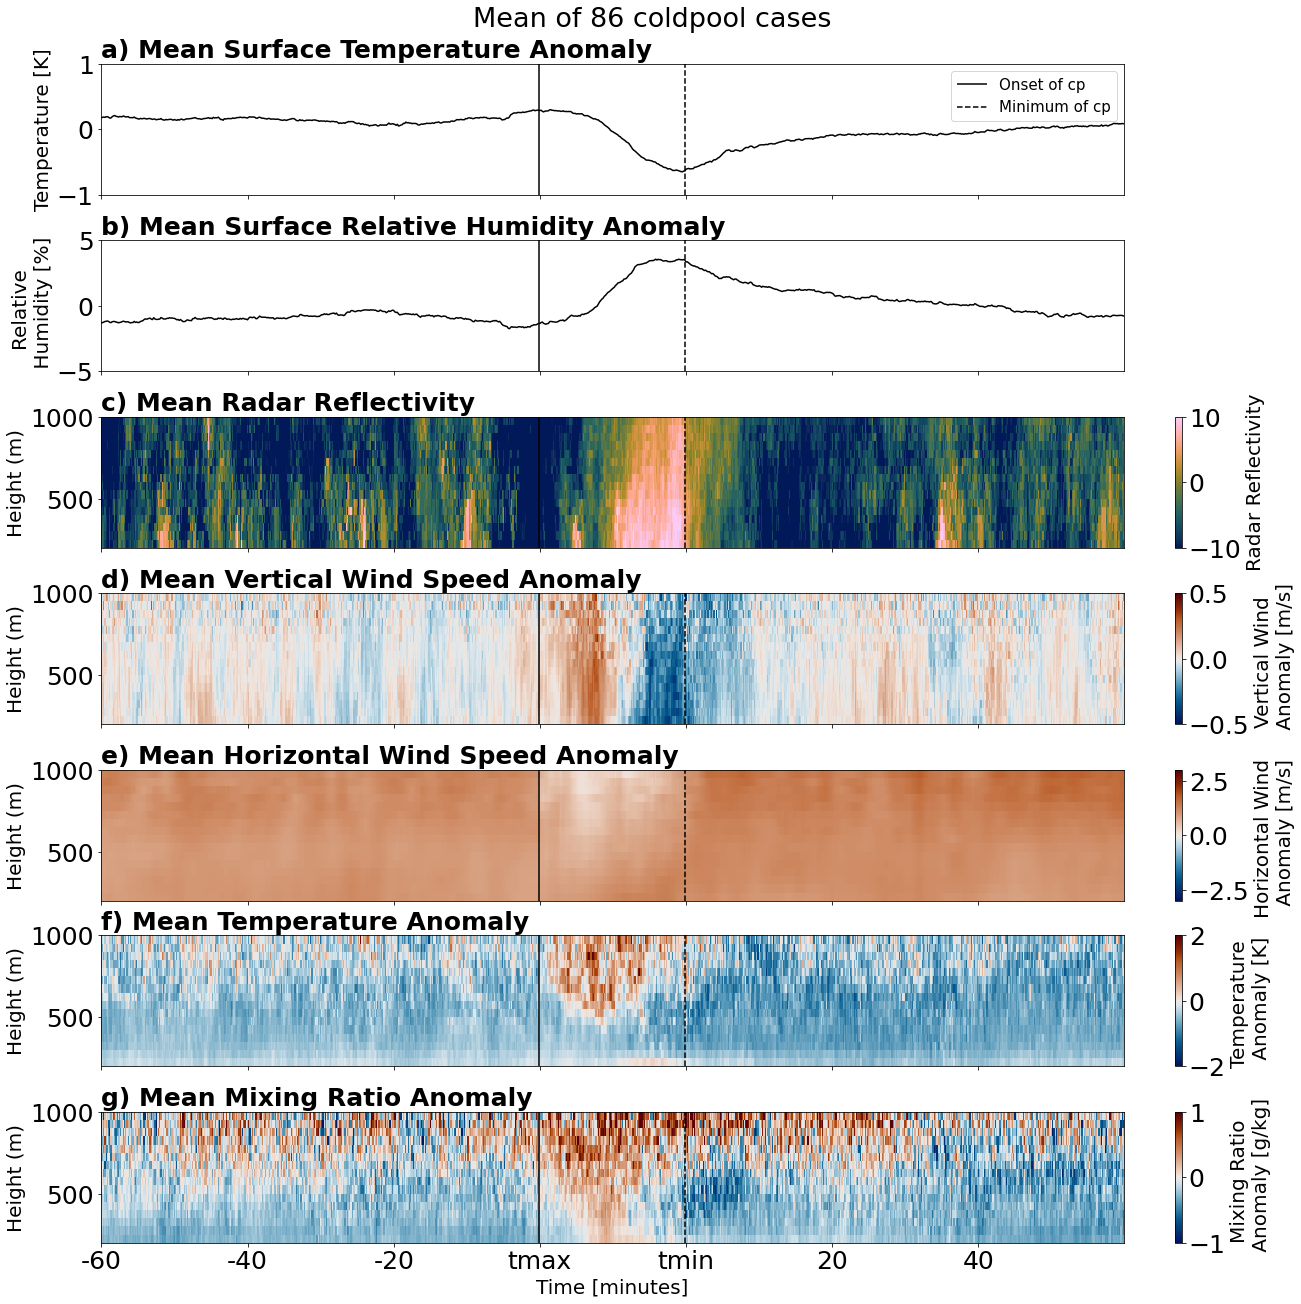

In [ ]:
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25


fig, axs = plt.subplots(7, figsize=(18,18), constrained_layout=True, sharex=True)
fig.suptitle('Mean of 86 coldpool cases', fontsize =27)#, fontweight='bold')

# Define custom x-axis labels
custom_labels = [-60, -40, -20, 'tmax', 'tmin', 20, 40]

# Select every 20-minute interval from the dataset for labeling
time_ticks = pd.date_range(start=ds_mean_start.Time[0].values, end=ds_mean_end.Time[-1].values, freq="20min")
CMAP_rr = cmc.batlow
CMAP = cmc.vik
i = 0
fs_axes = 20 #fontsize of axes
vmin = [-1, -5, -10, -0.5, -3, -2, -1]
vmax = [ 1,  5,  10,  0.5,  3,  2,  1]
variables = ['T_surface_anomaly', 'RH_surface_anomaly' ,'radar_reflectivity', 'VW_anomaly',  'H_Wind_anomaly', 'T_anomaly',  'MR_anomaly']
colorbar_label = ['Surface Temperature \n Anomaly [K]','Surface Relative Humidity Anomaly', 'Radar Reflectivity', 'Vertical Wind \n Anomaly [m/s]', 'Horizontal Wind \n Anomaly [m/s]', 'Temperature \n Anomaly [K]', 'Mixing Ratio \n Anomaly [g/kg]']
titles = ['a) Mean Surface Temperature Anomaly', 'b) Mean Surface Relative Humidity Anomaly', 'c) Mean Radar Reflectivity', 'd) Mean Vertical Wind Speed Anomaly', 'e) Mean Horizontal Wind Speed Anomaly','f) Mean Temperature Anomaly','g) Mean Mixing Ratio Anomaly']
for var in variables:
    
    if i == 0 or i ==1:
        axs[i].vlines(ds_mean_start.Time.values[-1], vmin[i], vmax[i], color = 'black', label = 'Onset of cp')
        axs[i].vlines(ds_mean_between.Time.values[-1], vmin[i], vmax[i], color = 'black', linestyle='--', label = 'Minimum of cp')
        axs[i].plot(ds_mean_all.Time.values, ds_mean_all[var].values, color='black')
        
        axs[i].set_ylim(vmin[i], vmax[i])

    elif i == 2:
        im0 = axs[i].pcolormesh(ds_mean_all.Time.values, ds_mean_all.Height.values, ds_mean_all[var].values.T,
                                       vmin = vmin[i],
                                       vmax = vmax[i], 
                                       cmap = CMAP_rr)
        colorbar = fig.colorbar(im0, ax=axs[i], orientation='vertical')
        colorbar.set_label(colorbar_label[i], fontsize=20)

        axs[i].vlines(ds_mean_start.Time.values[-1], 200, 1000, color = 'black', label = 'Onset of cp')
        axs[i].vlines(ds_mean_between.Time.values[-1], 200, 1000, color = 'black', linestyle = '--', label = 'Minimum of cp')

        
    
    else:
        im0 = axs[i].pcolormesh(ds_mean_all.Time.values, ds_mean_all.Height.values, ds_mean_all[var].values.T,
                                       vmin = vmin[i],
                                       vmax = vmax[i], 
                                       cmap = CMAP)
        colorbar = fig.colorbar(im0, ax=axs[i], orientation='vertical')
        colorbar.set_label(colorbar_label[i], fontsize=20)

        axs[i].vlines(ds_mean_start.Time.values[-1], 200, 1000, color = 'black', label = 'Onset of cp')
        axs[i].vlines(ds_mean_between.Time.values[-1], 200, 1000, color = 'black', linestyle = '--', label = 'Minimum of cp')
        
        
    
    axs[i].set_title(titles[i], loc='left', fontsize=25, fontweight='bold')
    i+=1

# Set the x-axis ticks to the 20-minute intervals
axs[0].set_xticks(time_ticks, labelsize=25)
# Replace the x-axis tick labels with custom labels
axs[0].set_xticklabels(custom_labels)
#ax[0].set_xlabel('')
axs[0].legend(fontsize=15)
axs[6].set_xlabel('Time [minutes]', fontsize = fs_axes)

# Set axis labels if needed
for ax in axs:
    ax.set_ylabel("Height (m)", fontsize=fs_axes)

axs[0].set_ylabel("Temperature [K]", fontsize=fs_axes)
axs[1].set_ylabel("Relative \n Humidity [%]", fontsize=fs_axes)

plt.savefig('Mean_of_86_coldpool_cases.png', bbox_inches="tight")

In [15]:
    
'''
# Step 2: Shift the selected times from all the datasets to the same time
## Shift the time of the '1hour before' datasets to 2000-01-01T00:00:00 - 2000-01-01T01:00:00 
# Define the start time and time interval
start_time = "2000-01-01T00:00:00"
time_interval = "10S"  # 10 seconds

# Loop over each dataset
for i, dss in enumerate(datasets_start):
    # Get the length of the current dataset's time coordinate
    original_time_length = len(dss.Time)
    
    # Generate the new time range with the same number of steps
    new_time = pd.date_range(start=start_time, periods=original_time_length, freq=time_interval)
    
    # Check if the dataset has the expected length
    if original_time_length != len(new_time):
        raise ValueError(f"Dataset {i} has a different time length than expected.")

    # Replace the time coordinate with the new time range
    dss = dss.assign_coords(Time=new_time)

    # Save the modified dataset back to the list
    datasets_start[i] = dss

## Shift the time of the '1hour after' datasets to 2000-01-01T01:20:00 - 2000-01-01T02:20:00 
start_end_time = '2000-01-01T01:20'
# Loop over each dataset
for i, dss in enumerate(datasets_end):
    # Get the length of the current dataset's time coordinate
    original_time_length = len(dss.Time)
    
    # Generate the new time range with the same number of steps
    new_time = pd.date_range(start=start_end_time, periods=original_time_length, freq=time_interval)
    
    # Check if the dataset has the expected length
    if original_time_length != len(new_time):
        raise ValueError(f"Dataset {i} has a different time length than expected.")

    # Replace the time coordinate with the new time range
    dss = dss.assign_coords(Time=new_time)

    # Save the modified dataset back to the list
    datasets_end[i] = dss
'''


'''
import xarray as xr
# 1 hour before start
# Step 3: Extract the 'anomaly' variable from each dataset
anomaly_list_start = [dss['anomaly'] for dss in datasets_start]

# Step 4: Concatenate along a new dimension called 'dataset'
anomaly_combined_start = xr.concat(anomaly_list_start, dim='dataset')

# Step 5: Calculate the mean along the 'dataset' dimension
anomaly_mean_start = anomaly_combined_start.mean(dim='dataset')


# 1 hour after minimum
# Step 3: Extract the 'anomaly' variable from each dataset
anomaly_list_end = [dss['anomaly'] for dss in datasets_end]

# Step 4: Concatenate along a new dimension called 'dataset'
anomaly_combined_end = xr.concat(anomaly_list_end, dim='dataset')

# Step 5: Calculate the mean along the 'dataset' dimension
anomaly_mean_end = anomaly_combined_end.mean(dim='dataset')
'''



'''
# take the mean:
# 1 hour after minimum
# Step 3: Extract the 'anomaly' variable from each dataset
anomaly_list_between = [dss['anomaly'] for dss in aligned_datasets]

# Step 4: Concatenate along a new dimension called 'dataset'
anomaly_combined_between = xr.concat(anomaly_list_between, dim='dataset')

# Step 5: Calculate the mean along the 'dataset' dimension
anomaly_mean_between = anomaly_combined_between.mean(dim='dataset')
'''


'''
## select for each coldpool datasets containing the time between the start and minimum of cp and put them in a list 
datasets_between = []
for i in range(0,len(tmax_indices)-12):
    ds_sel_between = ds.isel(time=slice(tmax_indices[i], tmin_indices[i]))
    T_anomaly_sel_between = T_anomaly_sel_h.sel(Time=slice(ds_sel_between.time.values[0], ds_sel_between.time.values[-1]))
    datasets_between.append(T_anomaly_sel_between)
'''   


'''
import xarray as xr
import pandas as pd

# Define the target number of timesteps
target_timesteps = 120


# Loop through each dataset and resample to 120 timesteps
for i, dss in enumerate(datasets_between):
    start_time = pd.to_datetime(dss.Time.values[0])
    end_time = pd.to_datetime(dss.Time.values[-1])
    
    # Calculate the interval in nanoseconds, then convert to seconds
    time_interval_ns = (end_time - start_time) / (target_timesteps - 1)
    time_interval_s = time_interval_ns / np.timedelta64(1, 's')
    
    # Generate the new time range with 120 points, each separated by the calculated interval
    new_time = [start_time + pd.Timedelta(seconds=j * time_interval_s) for j in range(target_timesteps)]
    
    # Interpolate dataset to the new time range
    ds_interp = dss.interp(Time=new_time)
    
    # Replace the original dataset with the resampled dataset
    datasets_between[i] = ds_interp

# reassingn the coordinates to the same timegrid e.g. 23:03, 23:05, 23:07 --> 01:01:10, 01:01:20, 01:01:30, 15:23, 15:33, 15:43 --> 01:01:10, 01:01:20, 01:01:30, ..... 

import xarray as xr
import pandas as pd

# Define the target time grid (same length as the datasets' time dimension)
start_time = "2000-01-01T01:00:00"
target_timesteps = 120  # Number of time points to align to
time_interval = "10S"   # Desired interval between time points

# Generate the target time grid
target_time_grid = pd.date_range(start=start_time, periods=target_timesteps, freq=time_interval)

# Loop through each dataset and replace the time coordinates
aligned_datasets = []
for i, dss in enumerate(datasets_between):
    # Ensure the dataset has the same number of timesteps as the target time grid
    if dss.dims['Time'] != target_timesteps:
        raise ValueError(f"Dataset {i} has a different number of timesteps than expected.")
    
    # Reassign the time coordinates directly
    ds_aligned = dss.assign_coords(Time=target_time_grid)
    
    # Store the aligned dataset
    aligned_datasets.append(ds_aligned)
'''

'\nimport xarray as xr\nimport pandas as pd\n\n# Define the target number of timesteps\ntarget_timesteps = 120\n\n\n# Loop through each dataset and resample to 120 timesteps\nfor i, dss in enumerate(datasets_between):\n    start_time = pd.to_datetime(dss.Time.values[0])\n    end_time = pd.to_datetime(dss.Time.values[-1])\n    \n    # Calculate the interval in nanoseconds, then convert to seconds\n    time_interval_ns = (end_time - start_time) / (target_timesteps - 1)\n    time_interval_s = time_interval_ns / np.timedelta64(1, \'s\')\n    \n    # Generate the new time range with 120 points, each separated by the calculated interval\n    new_time = [start_time + pd.Timedelta(seconds=j * time_interval_s) for j in range(target_timesteps)]\n    \n    # Interpolate dataset to the new time range\n    ds_interp = dss.interp(Time=new_time)\n    \n    # Replace the original dataset with the resampled dataset\n    datasets_between[i] = ds_interp\n\n# reassingn the coordinates to the same timegrid